In MOMENTA, it is possible to use a tabulated neutrino flux, for which we may want to constrain the normalisation and/or some shape parameters. This notebook introduces how the input should be formatted so that it can be used in MOMENTA and how to further use it in the analysis.

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import astropy.time
import numpy as np
import pandas as pd

from ultranest.plot import cornerplot
from momenta.io import NuDetector, Parameters, PointSource
from momenta.io.neutrinos import BackgroundFixed
from momenta.io.neutrinos_irfs import EffectiveAreaAllSky
from momenta.stats.run import run_ultranest
from momenta.stats.constraints import get_limits
import momenta.utils.flux as flux

# Starting remarks
* For the notebook to run, you need to install `momenta` as a package (`pip install -e .` from the root directory).
* It is better to keep this code at its current location as there are some relative paths defined here, though you may modify it.

# How to format the tabulated flux input

In this notebook, we build our tabulated fluxes from analytical functions. MOMENTA accepts tabulated fluxes with 1 or 2 free parameters.

## Example with 2 free parameters

Here, we use a broken power law with a fixed break energy.

In [2]:
bpl = flux.VariableBrokenPowerLaw(1e-1, 1e7, (2, 5, 16), (0, 3, 10), (3, 3, 1))

# The two spectral indices of the broken power law are the free parameters (alpha and beta).
spectral_idx1 = bpl.shapevar_grid[0]
spectral_idx2 = bpl.shapevar_grid[1] 

# We build the dataframe that will be our input as tabulated data. 
# It contains four columns (energy, flux, alpha, beta) and len(alphas)*len(betas)*len(energy) rows.
e_range = np.logspace(-1, 7, 100)
df_2d = []
for a in spectral_idx1:
    for b in spectral_idx2:
        bpl.set_shapevars([a, b, 3])
        fluxes = bpl.evaluate(e_range)
        df_2d.append(pd.DataFrame(
            {
                'energy': e_range,
                'flux': fluxes,
                'spectral_idx1': [a]*len(e_range),
                'spectral_idx2': [b]*len(e_range)
            }
        ))

df_2d = pd.concat(df_2d, ignore_index=True)
print(df_2d)

             energy          flux  spectral_idx1  spectral_idx2
0      1.000000e-01  1.000000e+02            2.0            0.0
1      1.204504e-01  6.892612e+01            2.0            0.0
2      1.450829e-01  4.750810e+01            2.0            0.0
3      1.747528e-01  3.274549e+01            2.0            0.0
4      2.104904e-01  2.257020e+01            2.0            0.0
...             ...           ...            ...            ...
15995  4.750810e+06  9.326033e-27            5.0            3.0
15996  5.722368e+06  5.336699e-27            5.0            3.0
15997  6.892612e+06  3.053856e-27            5.0            3.0
15998  8.302176e+06  1.747528e-27            5.0            3.0
15999  1.000000e+07  1.000000e-27            5.0            3.0

[16000 rows x 4 columns]


In [3]:
# The flux object (input for MOMENTA is built directly from the dataframe.
tab_flux = flux.VariableTabulated2D(df_2d)

## Example with 1 free parameter.

Again, we build our tabulated data from an analytical function, a single power-law.

In [4]:
spl = flux.VariablePowerLaw(1e-1, 1e7, gamma_range=(2, 3, 21))
gammas = spl.shapevar_grid[0]

e_range = np.logspace(-1, 7, 100)
df_1d = []
for g in gammas:
    spl.set_shapevars([g])
    fluxes = spl.evaluate(e_range)
    df_1d.append(pd.DataFrame(
        {
            'energy': e_range,
            'flux': fluxes,
            'gamma': [g]*len(e_range)
        }
    ))

df_1d = pd.concat(df_1d, ignore_index=True)
print(df_1d)

            energy          flux  gamma
0     1.000000e-01  1.000000e+02    2.0
1     1.204504e-01  6.892612e+01    2.0
2     1.450829e-01  4.750810e+01    2.0
3     1.747528e-01  3.274549e+01    2.0
4     2.104904e-01  2.257020e+01    2.0
...            ...           ...    ...
2095  4.750810e+06  9.326033e-21    3.0
2096  5.722368e+06  5.336699e-21    3.0
2097  6.892612e+06  3.053856e-21    3.0
2098  8.302176e+06  1.747528e-21    3.0
2099  1.000000e+07  1.000000e-21    3.0

[2100 rows x 3 columns]


In [5]:
flux_1d = flux.FluxBase()
flux_1d.components.append(flux.VariableTabulated1D(df_1d))

# Run analysis with 1D flux model

[2025-06-19 14:23:43,716:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.


145.634790580049 1.8993154491060786


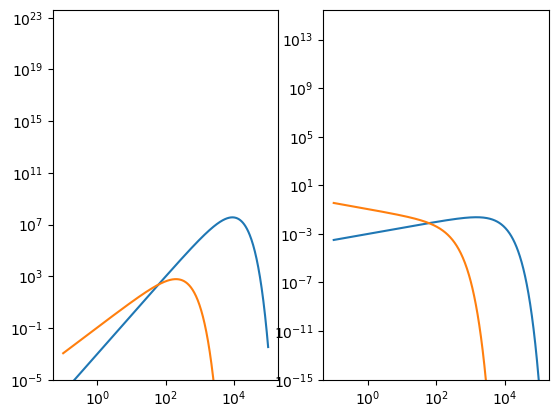

In [6]:
detector = NuDetector(
    {
        "name": "Detector",
        "samples": ["Sample1", "Sample2"],
    }
)

parameters = Parameters("input_files/config.yaml")
parameters.set_flux(flux=flux_1d)

source = PointSource(288.2645, 19.7735, 0, name="GRB 221009A", utc=astropy.time.Time("2022-10-09T13:17:00"))
source.set_redshift(0.151)

# Custom effective areas, constant over the full sky and just depending on energy
class EffAreaDet1(EffectiveAreaAllSky):
    def evaluate(self, energy, ipix, nside):
        return (energy / 10) ** 3 * np.exp(-energy / 3000)


class EffAreaDet2(EffectiveAreaAllSky):
    def evaluate(self, energy, ipix, nside):
        return (energy / 3) ** 2 * np.exp(-energy / 100)


detector.set_effective_areas([EffAreaDet1(), EffAreaDet2()])
detector.set_observations([20, 0], [BackgroundFixed(0.1), BackgroundFixed(0.1)])

In [7]:
_, result_tab = run_ultranest(detector, source, parameters)

[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=4e+01  
[ultranest] Likelihood function evaluations: 40917
[ultranest]   logZ = 29.54 +- 0.114
[ultranest] Effective samples strategy satisfied (ESS = 1898.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.10 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.10 to 0.32, need <0.3)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.30
[ultranest] done iterating.


Limit on E^2 dN/dE for tabulated = 17.12049624675917 GeV/cm²


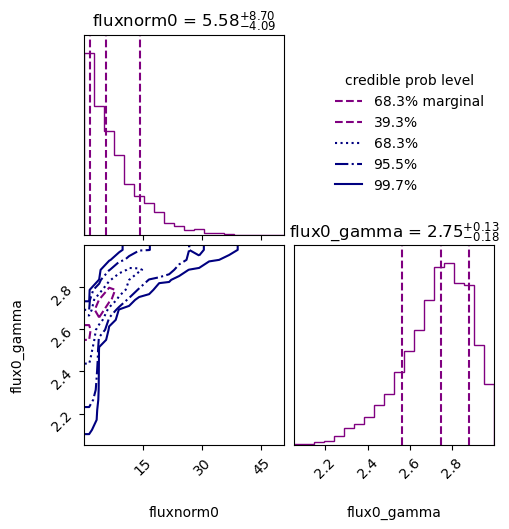

In [8]:
rc = result_tab
rc["paramnames"] = ["fluxnorm0", "flux0_gamma"]
rc["weighted_samples"]["points"] = np.array([rc["weighted_samples"]["points"][k] for k in rc["paramnames"]]).T
cornerplot(rc)

ul_tab = get_limits(result_tab)['fluxnorm0']
print(f"Limit on E^2 dN/dE for tabulated = {ul_tab} GeV/cm²")

## Check consistency with the analytic results

In [9]:
parameters.flux = flux.FluxBase()
parameters.flux.components.append(spl)
model_ana, result_ana = run_ultranest(detector, source, parameters)

[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=4e+01  
[ultranest] Likelihood function evaluations: 25318
[ultranest]   logZ = 29.47 +- 0.1216
[ultranest] Effective samples strategy satisfied (ESS = 1909.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.10 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.3)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.01 total:0.12 required:<0.30
[ultranest] done iterating.


Limit on E^2 dN/dE for tabulated = 17.12049624675917 GeV/cm²
Limit on E^2 dN/dE for analytic = 17.52668811901081 GeV/cm²


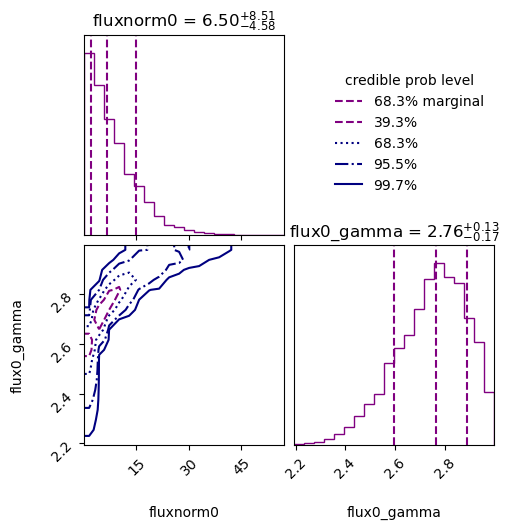

In [10]:
rc = result_ana
rc["paramnames"] = ["fluxnorm0", "flux0_gamma"]
rc["weighted_samples"]["points"] = np.array([rc["weighted_samples"]["points"][k] for k in rc["paramnames"]]).T
cornerplot(rc)

ul_ana = get_limits(result_ana)['fluxnorm0'] 
print(f"Limit on E^2 dN/dE for tabulated = {ul_tab} GeV/cm²")
print(f"Limit on E^2 dN/dE for analytic = {ul_ana} GeV/cm²")